In [1]:
# Data processing
import os
import pickle
import json
import pandas as pd
import numpy as np

# Multiprocessing
import multiprocessing
import tqdm
import itertools

# Viewing
from IPython.display import display

egocom_loc = "/datasets/cgn/EGOCOM/egocom_features/no_audio/"
seed = 0

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score

In [3]:
# names = [
# #     "Nearest Neighbors", 
# #     "Linear SVM", 
# #     "RBF SVM", 
# #     "Gaussian Process",
# #     "Logistic Regression",
# #     "Logistic Regression CV",
# #     "Decision Tree", 
#     "Random Forest", 
# #     "Neural Net", 
# #     "AdaBoost",
# #     "Naive Bayes", 
# #     "One layer SGD Classifier"
# #     "QDA",
# ]

# classifiers = [
# #     KNeighborsClassifier(3),
# #     SVC(kernel="linear", C=0.025),
# #     SVC(gamma=2, C=1),
# #     GaussianProcessClassifier(1.0 * RBF(1.0)),
# #     LogisticRegression(solver = 'lbfgs', multi_class='auto', max_iter = 500),
# #     LogisticRegressionCV(cv = 5, Cs=10, solver = 'lbfgs', multi_class='auto', max_iter = 200),
# #     DecisionTreeClassifier(max_depth=10),
#     RandomForestClassifier(max_depth=12, n_estimators=150),
# #     MLPClassifier(alpha=1),
# #     AdaBoostClassifier(),
# #     GaussianNB(),
# #     SGDClassifier(max_iter=1000, tol=1e-3),
# #     QuadraticDiscriminantAnalysis(),
# ]

# assert(len(names) == len(classifiers))

In [4]:
video_info = pd.read_csv("/datasets/cgn/EGOCOM/video_info.csv")

In [5]:
kinds = ['text', 'video', 'voxaudio'] # ['audio', 'text', 'video', 'voxaudio']
cols = pd.read_csv(egocom_loc + "egocom_features_history_4sec.csv.gz").columns
experiments = list(itertools.chain.from_iterable(itertools.combinations(kinds, r) for r in range(len(kinds)+1)))[1:]
experiments = {"_".join(e): [c for c in cols if c.split("_")[0] in [z+"feat" for z in e]] for e in experiments}
label_shifts = [0, 2, 4, 9] # translates to [1,3,5,10] seconds respectively

In [6]:
def shift_labels(x, shift = 0):
    '''Move labels forward by advance_labels and removes the extra data.
    
    Parameters
    ----------
    x : pandas DataFrame
      contains features and labels for a ['video_id', 'video_speaker_id'] group
    shift : int
      how far to advance the labels in time (seconds).'''
    if x.name == 'multiclass_speaker_label' or x.name == 'is_speaking':
        return x[shift:].values
    else:
        return x[:-shift].values if shift > 0 else x.values
    
# # Test code to check that shift_labels does nothing for a shift of 0
# new_data = pd.concat([sdf.apply(shift_data, shift = label_shift) for i, sdf in data.groupby(['video_id', 'video_speaker_id'])], ignore_index=True)
# assert(all(new_data.sort_values(by=['video_id', 'clip_id']).reset_index(drop=True) == data.sort_values(by=['video_id', 'clip_id']).reset_index(drop=True)))

In [7]:
def process_multiclass_job(job):
    '''Multiprocessing multiple experiments at the same time.
    Each jobs = (experiment_key, label_shift).
    where:
      experiment_key : indexes the experiments dictionary
      label_shift : how many seconds in future to shift labels'''
    np.random.seed(seed=seed)
    experiment_key, label_shift = job
    experiment = experiments[experiment_key]
    # Shift the labels as far in the future as defined by label_shift (~60 seconds)
    new_data = pd.concat([sdf.apply(shift_labels, shift = label_shift) for i, sdf in data.groupby(['video_id', 'video_speaker_id'])], ignore_index=True)
    # Combine all three speakers to single input for each conversation
    X = new_data.groupby(["conversation_id", "clip_id", "multiclass_speaker_label", "test", "train"]).apply(lambda x: x[experiment].values.flatten()).reset_index()
    # The code below asserts that the first features are speaker 1, 
    # second features are speaker 2, third features are speaker 3 (works bc data is presorted.)
#     dfby = new_data.groupby(["conversation_id", "clip_id", "multiclass_speaker_label"])
#     assert(all(dfby.apply(lambda x: all(x['video_speaker_id'] == [1,2,3]) if len(x) == 3 else True)))
    
    # Only include examples with all three speakers (same dimension)
    # this occurs at the end of a video (if one speaker's video is ~1s longer than the others)
    # then there will be features for that speaker but not the other speakers.
    input_length = max([len(z) for z in X[0]])
    mask = [len(z) == input_length for z in X[0]]
    X = X[mask]    
    
    if use_crossval:
        # Compute cross-validation accuracy
        y = X['multiclass_speaker_label'].values
        
        X = np.stack(X[0])
        score = np.mean(cross_val_score(classifier, X, y, cv = 5, n_jobs = 1, verbose = 1))
        print(experiment_key, "label_shift:", label_shift, X.shape, y.shape, "num features:", len(experiment), score)
    else:
        # Compute test accuracy
        X_train = np.stack(X[X['train']][0])
        X_test = np.stack(X[X['test']][0])
        y_train = X[X['train']]['multiclass_speaker_label'].values
        y_test = X[X['test']]['multiclass_speaker_label'].values
        classifier.fit(X_train, y_train)
        score = classifier.score(X_test, y_test)
        print(experiment_key, "label_shift:", label_shift, X_train.shape, y_train.shape, "num feats", len(experiment), score)
    return score

In [12]:
X_train = np.stack(X[X['train']][0])
X_test = np.stack(X[X['test']][0])
y_train = X[X['train']]['multiclass_speaker_label'].values
y_test = X[X['test']]['multiclass_speaker_label'].values

In [11]:
experiment = experiments[list(experiments.keys())[0]]
X = data.groupby(["conversation_id", "clip_id", "multiclass_speaker_label", "test", "train"]).apply(lambda x: x[experiment].values.flatten()).reset_index()
    # The code below asserts that the first features are speaker 1, 
    # second features are speaker 2, third features are speaker 3 (works bc data is presorted.)
#     dfby = new_data.groupby(["conversation_id", "clip_id", "multiclass_speaker_label"])
#     assert(all(dfby.apply(lambda x: all(x['video_speaker_id'] == [1,2,3]) if len(x) == 3 else True)))
    
    # Only include examples with all three speakers (same dimension)
    # this occurs at the end of a video (if one speaker's video is ~1s longer than the others)
# then there will be features for that speaker but not the other speakers.
input_length = max([len(z) for z in X[0]])
mask = [len(z) == input_length for z in X[0]]
X = X[mask]    

In [ ]:
np.random.seed(seed=seed)
experiment_key, label_shift = job
experiment = experiments[experiment_key]
# Shift the labels as far in the future as defined by label_shift (~60 seconds)
new_data = pd.concat([sdf.apply(shift_labels, shift = label_shift) for i, sdf in data.groupby(['video_id', 'video_speaker_id'])], ignore_index=True)
# Combine all three speakers to single input for each conversation
X = new_data.groupby(["conversation_id", "clip_id", "multiclass_speaker_label", "test", "train"]).apply(lambda x: x[experiment].values.flatten()).reset_index()
# The code below asserts that the first features are speaker 1, 
# second features are speaker 2, third features are speaker 3 (works bc data is presorted.)
#     dfby = new_data.groupby(["conversation_id", "clip_id", "multiclass_speaker_label"])
#     assert(all(dfby.apply(lambda x: all(x['video_speaker_id'] == [1,2,3]) if len(x) == 3 else True)))

# Only include examples with all three speakers (same dimension)
# this occurs at the end of a video (if one speaker's video is ~1s longer than the others)
# then there will be features for that speaker but not the other speakers.
input_length = max([len(z) for z in X[0]])
mask = [len(z) == input_length for z in X[0]]
X = X[mask]    

In [10]:
# Try all history_lengths, and all experiments (different inputs), and all label shifts
jobs = list(itertools.product(experiments.keys(), label_shifts))
all_results = {}
for use_crossval in [False, True]:
    for classifier in [GaussianNB(), RandomForestClassifier(random_state=seed, max_depth=12, n_estimators=150)]:
        key = " ".join([
            "use_crossval:", str(use_crossval), "| clf:", str(type(classifier)),
        ])
        print(key)
        results = {}
        for history_length in [4, 5, 10, 30]:
            # Fetch and prepare data
            data = pd.read_csv(egocom_loc + "egocom_features_history_{}sec.csv.gz".format(history_length))
            # -1 means no one is speaking. Change to 0 for training.
            data["multiclass_speaker_label"].replace(-1, 0, inplace = True)
            # Include video info and pre-sort data by speaker_id within each video.
            data = pd.merge(data, video_info, on = ['video_id', 'video_speaker_id'])
            print(data.shape)

            # Only use 3 speaker conversations
            data = data[data['num_speakers'] == 3]
            # All the work  is done here.
            with multiprocessing.Pool(multiprocessing.cpu_count() // 2) as p:
                result = list(tqdm.tqdm(p.imap(process_multiclass_job, jobs), total=len(jobs)))
            results[history_length] = list(zip(jobs, result))
            print(key)
            print(results) 
        all_results[key] = results
        

use_crossval: False | clf: <class 'sklearn.naive_bayes.GaussianNB'>
(136431, 2881)


# old notes below -- NOTHING BELOW HERE USED FOR FINAL PAPER

In [ ]:
# Try all history_lengths, and all experiments (different inputs), and all label shifts
jobs = list(itertools.product(experiments.keys(), label_shifts))
results = {}
for history_length in [4, 5, 10, 30]:
    # Fetch and prepare data
    data = pd.read_csv(egocom_loc + "egocom_features_history_{}sec.csv.gz".format(history_length))
    # -1 means no one is speaking. Change to 0 for training.
    data["multiclass_speaker_label"].replace(-1, 0, inplace = True)
    # Include video info
    data = pd.merge(data, video_info, on = ['video_id', 'video_speaker_id'])
    print(data.shape)

    # Only use 3 speaker conversations
    data = data[data['num_speakers'] == 3]
    with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
        result = list(tqdm.tqdm(p.imap(process__multiclass_job, jobs), total=len(jobs)))
    results[history_length] = list(zip(jobs, result))
    print(results)
        

In [31]:
final_results.sum(axis = 1)

4     3.520053
5     3.419520
10    3.366168
30    2.070473
60    1.978806
dtype: float64

In [30]:
final_results.sum(axis = 0)

all            2.151534
text_audio     2.337081
text_video     1.769310
video_audio    2.093163
text           1.982223
audio          2.522749
video          1.498961
dtype: float64

In [36]:
from matplotlib import pyplot as plt

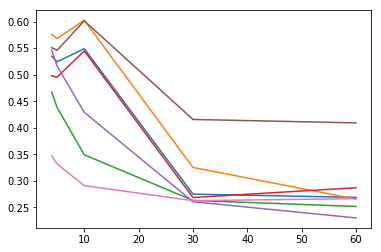

In [40]:
_ = plt.plot(final_results)

In [34]:
final_results = pd.DataFrame({k:[i[1] for i in v] for k, v in results.items()}).T
final_results.columns = experiments.keys()
final_results.round(3)

,all,text_audio,text_video,video_audio,text,audio,video
4,0.535,0.576,0.467,0.498,0.546,0.551,0.347
5,0.524,0.568,0.438,0.495,0.516,0.546,0.332
10,0.549,0.602,0.349,0.545,0.429,0.601,0.291
30,0.275,0.325,0.263,0.269,0.261,0.416,0.263
60,0.269,0.266,0.252,0.287,0.230,0.409,0.266


In [12]:
def process_job(x):
    '''Multiprocesasing multiple classifiers at the same time'''
    name, clf = x
    score = cross_val_score(clf, X, y, cv = 5, n_jobs = 1, verbose = 1)
    print(name, np.mean(score))
    return score

In [14]:
results = {}
for history_length in [4, 5, 10, 30, 60]:
    # Fetch and prepare data
    data = pd.read_csv(egocom_loc + "egocom_features_history_{}sec.csv.gz".format(history_length))
    # -1 means no one is speaking. Change to 0 for training.
    data["multiclass_speaker_label"].replace(-1, 0, inplace = True)
    # Include video info
    data = pd.merge(data, video_info, on = ['video_id', 'video_speaker_id'])
    print(data.shape)

    # Only use 3 speaker conversations
    data = data[data['num_speakers'] == 3]
         
    for experiment_key in experiments.keys():
        experiment = experiments[experiment_key]

        # Combine all three speakers to single input for each conversation
        X = data.groupby(["conversation_id", "clip_id", "multiclass_speaker_label"]).apply(lambda x: x[experiment].values.flatten()).reset_index()
        # Get labels
        y = X['multiclass_speaker_label'].values
        # Only include examples with all three speakers (same dimension)
        input_length = max([len(z) for z in X[0]])
        mask = [len(z) == input_length for z in X[0]]
        X = np.stack(X[0][mask])
        y = y[mask]
        
        print(X.shape, y.shape, len(experiment))

        with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
            result = list(tqdm.tqdm(p.imap(process_job, zip(names, classifiers)), total=len(classifiers)))
        results[(history_length, experiment_key)] = list(zip(names, [np.mean(i) for i in result]))
        
        print(results)
        

(24089, 3451)
(5508, 10308) (5508,) 3436


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   32.8s remaining:   49.3s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   33.1s finished


[0.53127833 0.54215775 0.53448276 0.53363636 0.53454545]
{}
(5508, 4164) (5508,) 1388


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   17.8s remaining:   26.7s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   18.6s finished


[0.54397099 0.56572983 0.646098   0.59727273 0.54727273]
{}
(5508, 7044) (5508,) 2348


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   26.7s remaining:   40.1s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   27.6s finished


[0.50045331 0.49682684 0.47277677 0.40818182 0.50636364]
{}
(5508, 9408) (5508,) 3136


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   31.3s remaining:   47.0s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   31.7s finished


[0.50589302 0.54306437 0.47005445 0.48818182 0.47636364]
{}
(5508, 900) (5508,) 300


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.8s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:    5.9s finished


[0.49682684 0.54306437 0.59255898 0.53909091 0.53      ]
{}
(5508, 3264) (5508,) 1088


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   16.5s remaining:   24.8s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   17.2s finished


[0.51858568 0.55303717 0.57441016 0.56181818 0.49636364]
{}
(5508, 6144) (5508,) 2048


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   26.2s remaining:   39.3s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   27.0s finished


[0.44424297 0.3862194  0.2477314  0.27454545 0.34636364]
{}
(24389, 3451)
(5486, 10308) (5486,) 3436


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   31.8s remaining:   47.8s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   32.7s finished


[0.53139217 0.54644809 0.53460838 0.51186131 0.51232877]
{}
(5486, 4164) (5486,) 1388


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   17.7s remaining:   26.6s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   18.3s finished


[0.54231119 0.56284153 0.60382514 0.60036496 0.53242009]
{}
(5486, 7044) (5486,) 2348


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   26.6s remaining:   39.9s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   27.4s finished


[0.46860783 0.44808743 0.42349727 0.38229927 0.46027397]
{}
(5486, 9408) (5486,) 3136


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   31.0s remaining:   46.6s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   31.2s finished


[0.50864422 0.54007286 0.48724954 0.47992701 0.48219178]
{}
(5486, 900) (5486,) 300


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    6.1s remaining:    9.2s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:    6.3s finished


[0.48134668 0.52094718 0.56830601 0.52372263 0.51050228]
{}
(5486, 3264) (5486,) 1088


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   16.5s remaining:   24.7s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   16.7s finished


[0.52320291 0.56193078 0.58469945 0.54562044 0.49771689]
{}
(5486, 6144) (5486,) 2048


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   26.2s remaining:   39.3s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   27.1s finished


[0.43312102 0.37431694 0.26320583 0.27189781 0.35342466]
{}
(28220, 3451)
(5378, 10308) (5378,) 3436


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   31.7s remaining:   47.5s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   32.2s finished


[0.52553389 0.57660167 0.56040892 0.52651163 0.52562908]
{}
(5378, 4164) (5378,) 1388


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   18.0s remaining:   26.9s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   18.7s finished


[0.55246054 0.60538533 0.65055762 0.61581395 0.54892824]
{}
(5378, 7044) (5378,) 2348


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   26.5s remaining:   39.7s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   27.2s finished


[0.42989786 0.37511606 0.29275093 0.28186047 0.37092265]
{}
(5378, 9408) (5378,) 3136


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   30.4s remaining:   45.6s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   31.4s finished


[0.53296193 0.59238626 0.56319703 0.53395349 0.51351351]
{}
(5378, 900) (5378,) 300


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.5s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:    7.2s finished


[0.44568245 0.4187558  0.45260223 0.43627907 0.39794967]
{}


KeyboardInterrupt: 

In [ ]:
results = {}
for history_length in [4, 5, 10, 30, 60]:
    # Fetch and prepare data
    data = pd.read_csv(egocom_loc + "egocom_features_history_{}sec.csv.gz".format(history_length))
    # -1 means no one is speaking. Change to 0 for training.
    data["multiclass_speaker_label"].replace(-1, 0, inplace = True)
    # Include video info
    data = pd.merge(data, video_info, on = ['video_id', 'video_speaker_id'])
    print(data.shape)

    # Only use 3 speaker conversations
    data = data[data['num_speakers'] == 3]
         
    for experiment_key in experiments.keys():
        experiment = experiments[experiment_key]

        # Combine all three speakers to single input for each conversation
        X = data.groupby(["conversation_id", "clip_id", "multiclass_speaker_label"]).apply(lambda x: x[experiment].values.flatten()).reset_index()
        # Get labels
        y = X['multiclass_speaker_label'].values
        # Only include examples with all three speakers (same dimension)
        input_length = max([len(z) for z in X[0]])
        mask = [len(z) == input_length for z in X[0]]
        X = np.stack(X[0][mask])
        y = y[mask]
        
        print(X.shape, y.shape, len(experiment))

        with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
            result = list(tqdm.tqdm(p.imap(process_job, zip(names, classifiers)), total=len(classifiers)))
        results[(history_length, experiment_key)] = list(zip(names, [np.mean(i) for i in result]))
        
        print(results)
        

(24074, 3451)
(5508, 10308) (5508,) 3436



  0%|          | 0/7 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/cgn/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.3s finished


Naive Bayes 0.4008506279081402


/home/cgn/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.5min finished


Random Forest 0.5121637290429255


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.6min finished


One layer SGD Classifier 0.3036989304952981


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 11.9min finished


Decision Tree 0.41085783854743674


/home/cgn/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [180]:
# X = data[[c for c in data.columns if 'textfeat' in c]].values
# y = data['multiclass_speaker_label'].values

In [ ]:
def process_job(x):
    name, clf = x
    score = cross_val_score(clf, X, y, cv = 5, n_jobs = 2, verbose = 1)
    print(name, score)
    return score
with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
    results = list(tqdm.tqdm(p.imap(process_job, zip(names, classifiers)), total=len(classifiers)))


  0%|          | 0/9 [00:00<?, ?it/s]/home/cgn/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:673: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  **self._backend_args)
/home/cgn/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:673: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  **self._backend_args)
/home/cgn/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:673: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  **self._backend_args)
/home/cgn/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:673: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  **self._backend_args)
/home/cgn/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:673: UserWarning: Loky-backed pa

Random Forest [0.65064728 0.65029261 0.65064728 0.65058531 0.65034593]


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   29.6s finished


Naive Bayes [0.69107998 0.74144352 0.69498138 0.59968074 0.62320383]


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.7min finished


Decision Tree [0.71218301 0.75846781 0.73027132 0.69244413 0.65034593]


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  8.8min finished


QDA [0.65082461 0.63344565 0.62316013 0.62965591 0.65034593]


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 13.1min finished


Neural Net [0.72920731 0.75101968 0.71768044 0.68304363 0.66436048]


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 37.6min finished


AdaBoost [0.72175918 0.75084235 0.72778862 0.6837531  0.66187688]


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 204.2min finished


Linear SVM [0.73310871 0.76556127 0.74215286 0.6936857  0.66400568]



 11%|█         | 1/9 [3:24:13<27:13:44, 12253.09s/it]

In [ ]:
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   18.4s finished
Random Forest [0.65064728 0.65029261 0.65064728 0.65058531 0.65034593]

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   29.6s finished
Naive Bayes [0.69107998 0.74144352 0.69498138 0.59968074 0.62320383]

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.7min finished
Decision Tree [0.71218301 0.75846781 0.73027132 0.69244413 0.65034593]

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   5.0min finished
Logistic Regression [0.7120056 0.7281432 0.6788437 0.6468605 0.6471527]

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  8.8min finished
QDA [0.65082461 0.63344565 0.62316013 0.62965591 0.65034593]

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 13.1min finished
Neural Net [0.72920731 0.75101968 0.71768044 0.68304363 0.66436048]

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 37.6min finished
AdaBoost [0.72175918 0.75084235 0.72778862 0.6837531  0.66187688]

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 204.2min finished
Linear SVM [0.73310871 0.76556127 0.74215286 0.6936857  0.66400568]

In [257]:
# 1 if egocentric speaker is talking, 0 otherwise.
binary_labels = [[int(int(v[30]) == l) for l in labels[i]] for i, v in enumerate(vid2name)]

In [258]:
# Combine all data back together
X = np.stack(pd.concat(visual_features).feature)
y = np.array([l for lst in binary_labels for l in lst])
# Check that labels and data match
assert(len(y) == len(df.feature))

In [298]:
pred = clf.predict(X_test)
acc = sum(pred == y_test) / len(y_test)
print('Accuracy:', acc)
print('Accuracy if you just predict 0:', sum(y_test == 0) / len(y_test))

Accuracy: 0.6954311454311455
Accuracy if you just predict 0: 0.6579150579150579


In [295]:
pred = clf.predict(X_test)
acc = sum(pred == y_test) / len(y_test)
print('Accuracy:', acc)
print('Accuracy if you just predict 0:', sum(y_test == 0) / len(y_test))

Accuracy: 0.6991956241956242
Accuracy if you just predict 0: 0.6579150579150579


In [1]:
{(4, 'all'): [('Logistic Regression', 0.26434046058509464),
  ('Logistic Regression CV', 0.4769291670538231),
  ('Decision Tree', 0.41085783854743674),
  ('Random Forest', 0.5121637290429255),
  ('Neural Net', 0.31241768220772076),
  ('Naive Bayes', 0.4008506279081402),
  ('One layer SGD Classifier', 0.3036989304952981)],
 (4, 'text_audio'): [('Logistic Regression', 0.4642568062097506),
  ('Logistic Regression CV', 0.5463106757487605),
  ('Decision Tree', 0.47226895577363387),
  ('Random Forest', 0.5652082365442299),
  ('Neural Net', 0.49677034477172066),
  ('Naive Bayes', 0.49076276722726925),
  ('One layer SGD Classifier', 0.46858591656004983)],
 (4, 'text_video'): [('Logistic Regression', 0.1960630076216207),
  ('Logistic Regression CV', 0.38461651144672604),
  ('Decision Tree', 0.3765606977868948),
  ('Random Forest', 0.4418958406297427),
  ('Neural Net', 0.2568454423946994),
  ('Naive Bayes', 0.3428881451514914),
  ('One layer SGD Classifier', 0.22125580436807732)],
 (4, 'video_audio'): [('Logistic Regression', 0.26433059345717574),
  ('Logistic Regression CV', 0.47674899398895),
  ('Decision Tree', 0.38454849819049053),
  ('Random Forest', 0.4791050563818863),
  ('Neural Net', 0.29919396655445085),
  ('Naive Bayes', 0.38177814627126677),
  ('One layer SGD Classifier', 0.2761431382779759)],
 (4, 'text'): [('Logistic Regression', 0.5390662251892302),
  ('Logistic Regression CV', 0.5492500089343787),
  ('Decision Tree', 0.4541088767222504),
  ('Random Forest', 0.5216656231312258),
  ('Neural Net', 0.5545076097082151),
  ('Naive Bayes', 0.4330370145356387),
  ('One layer SGD Classifier', 0.5256228751069147)],
 (4, 'audio'): [('Logistic Regression', 0.43376234671584146),
  ('Logistic Regression CV', 0.5450520921932589),
  ('Decision Tree', 0.4613621973330284),
  ('Random Forest', 0.5457773743409408),
  ('Neural Net', 0.4642657012772588),
  ('Naive Bayes', 0.48260990238893375),
  ('One layer SGD Classifier', 0.4290251925656438)],
 (4, 'video'): [('Logistic Regression', 0.19243026538678712),
  ('Logistic Regression CV', 0.3822538614385064),
  ('Decision Tree', 0.2870246398254103),
  ('Random Forest', 0.3165307795305044),
  ('Neural Net', 0.21460550310082507),
  ('Naive Bayes', 0.3150745675165048),
  ('One layer SGD Classifier', 0.19824877122510584)],
 (5, 'all'): [('Logistic Regression', 0.2552199414721667),
  ('Logistic Regression CV', 0.48028749560346656),
  ('Decision Tree', 0.40665104143582875),
  ('Random Forest', 0.5025270775817123),
  ('Neural Net', 0.2991503203808775),
  ('Naive Bayes', 0.409040971635631),
  ('One layer SGD Classifier', 0.27837256273927236)],
 (5, 'text_audio'): [('Logistic Regression', 0.44418324686206123),
  ('Logistic Regression CV', 0.5460641160553049),
  ('Decision Tree', 0.4518661030946823),
  ('Random Forest', 0.5506188508580693),
  ('Neural Net', 0.45111222304832754),
  ('Naive Bayes', 0.5072262327603234),
  ('One layer SGD Classifier', 0.4467501807656452)]}


{(4, 'all'): [('Logistic Regression', 0.26434046058509464),
  ('Logistic Regression CV', 0.4769291670538231),
  ('Decision Tree', 0.41085783854743674),
  ('Random Forest', 0.5121637290429255),
  ('Neural Net', 0.31241768220772076),
  ('Naive Bayes', 0.4008506279081402),
  ('One layer SGD Classifier', 0.3036989304952981)],
 (4, 'text_audio'): [('Logistic Regression', 0.4642568062097506),
  ('Logistic Regression CV', 0.5463106757487605),
  ('Decision Tree', 0.47226895577363387),
  ('Random Forest', 0.5652082365442299),
  ('Neural Net', 0.49677034477172066),
  ('Naive Bayes', 0.49076276722726925),
  ('One layer SGD Classifier', 0.46858591656004983)],
 (4, 'text_video'): [('Logistic Regression', 0.1960630076216207),
  ('Logistic Regression CV', 0.38461651144672604),
  ('Decision Tree', 0.3765606977868948),
  ('Random Forest', 0.4418958406297427),
  ('Neural Net', 0.2568454423946994),
  ('Naive Bayes', 0.3428881451514914),
  ('One layer SGD Classifier', 0.22125580436807732)],
 (4, 'video_au